# Presentación

## Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

## Setup

### Instalar dependencias

In [274]:
pip install -r ../requirements.txt

4343.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Cargar bibliotecas

In [49]:
# Manipulacion de datos y funciones matemáticas
import pandas as pd
import numpy as np
from datetime import datetime
import calendar

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Entrenamiento y evaluacion de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Metricas para evaluar modelos
from sklearn import metrics

### Cargar Dataset

In [87]:
hoteles_ds = pd.read_csv('../datasets/hotels_train.csv')
hoteles_test_ds = pd.read_csv('../datasets/hotels_test.csv')

## Checkpoint 1

### Exploración inicial de datos

In [52]:
print(hoteles_ds.shape)
hoteles_ds.head(n=2)

(61913, 32)


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,9.0,NaN,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,NaN,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


Arreglo columnas dtype

In [53]:
# Separamos variables categoricas y numericas
# Vamos a tomar las categoricas como strings y las numericas como int o float

# Esta informacion la sacamos del paper del dataset
categoric_variables = ['agent', 'arrival_date_month', 'assigned_room_type', 'company', 'country', 'customer_type', 'deposit_type', 'distribution_channel', 'hotel', 'is_repeated_guest', 'market_segment', 'meal', 'reservation_status_date', 'reserved_room_type']
int_variables = ['adults', 'arrival_date_day_of_month', 'arrival_date_week_number', 'arrival_date_year', 'babies', 'booking_changes', 'children', 'days_in_waiting_list', 'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 'required_car_parking_spaces', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests']
float_variables = ['ad']


def isfloat(value):
    try:
        float(value)
        return True
    except:
        return False

def parse_columns(df):
    # Vamos a convertir todas las columnas con datos categoricos a tipo 'string'
    # y vamos a eliminar los datos con coma que no tienen sentido para este tipo de variables
    df[categoric_variables] = df[categoric_variables].astype('string')
    for col in categoric_variables:
        #values = df[col].str.split('.')
        values = df[col]
        # Elimina la parte flotante. Pone como NaN los vacios
        for i, value in enumerate(values):
            if isfloat(value):
                values[i] = str(int(float(value)))
                continue
            if str(value) == str(pd.NA):
                continue

        
        df[col] = values
    df[categoric_variables] = df[categoric_variables].astype('string')


parse_columns(hoteles_ds)
parse_columns(hoteles_test_ds)
print('Variables Categoricas: ', categoric_variables)
print('Variables Enteras: ', int_variables)
print('Variables Floatantes: ', float_variables)

Variables Categoricas:  ['agent', 'arrival_date_month', 'assigned_room_type', 'company', 'country', 'customer_type', 'deposit_type', 'distribution_channel', 'hotel', 'is_repeated_guest', 'market_segment', 'meal', 'reservation_status_date', 'reserved_room_type']
Variables Enteras:  ['adults', 'arrival_date_day_of_month', 'arrival_date_week_number', 'arrival_date_year', 'babies', 'booking_changes', 'children', 'days_in_waiting_list', 'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 'required_car_parking_spaces', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests']
Variables Floatantes:  ['ad']


### Visualización de los datos

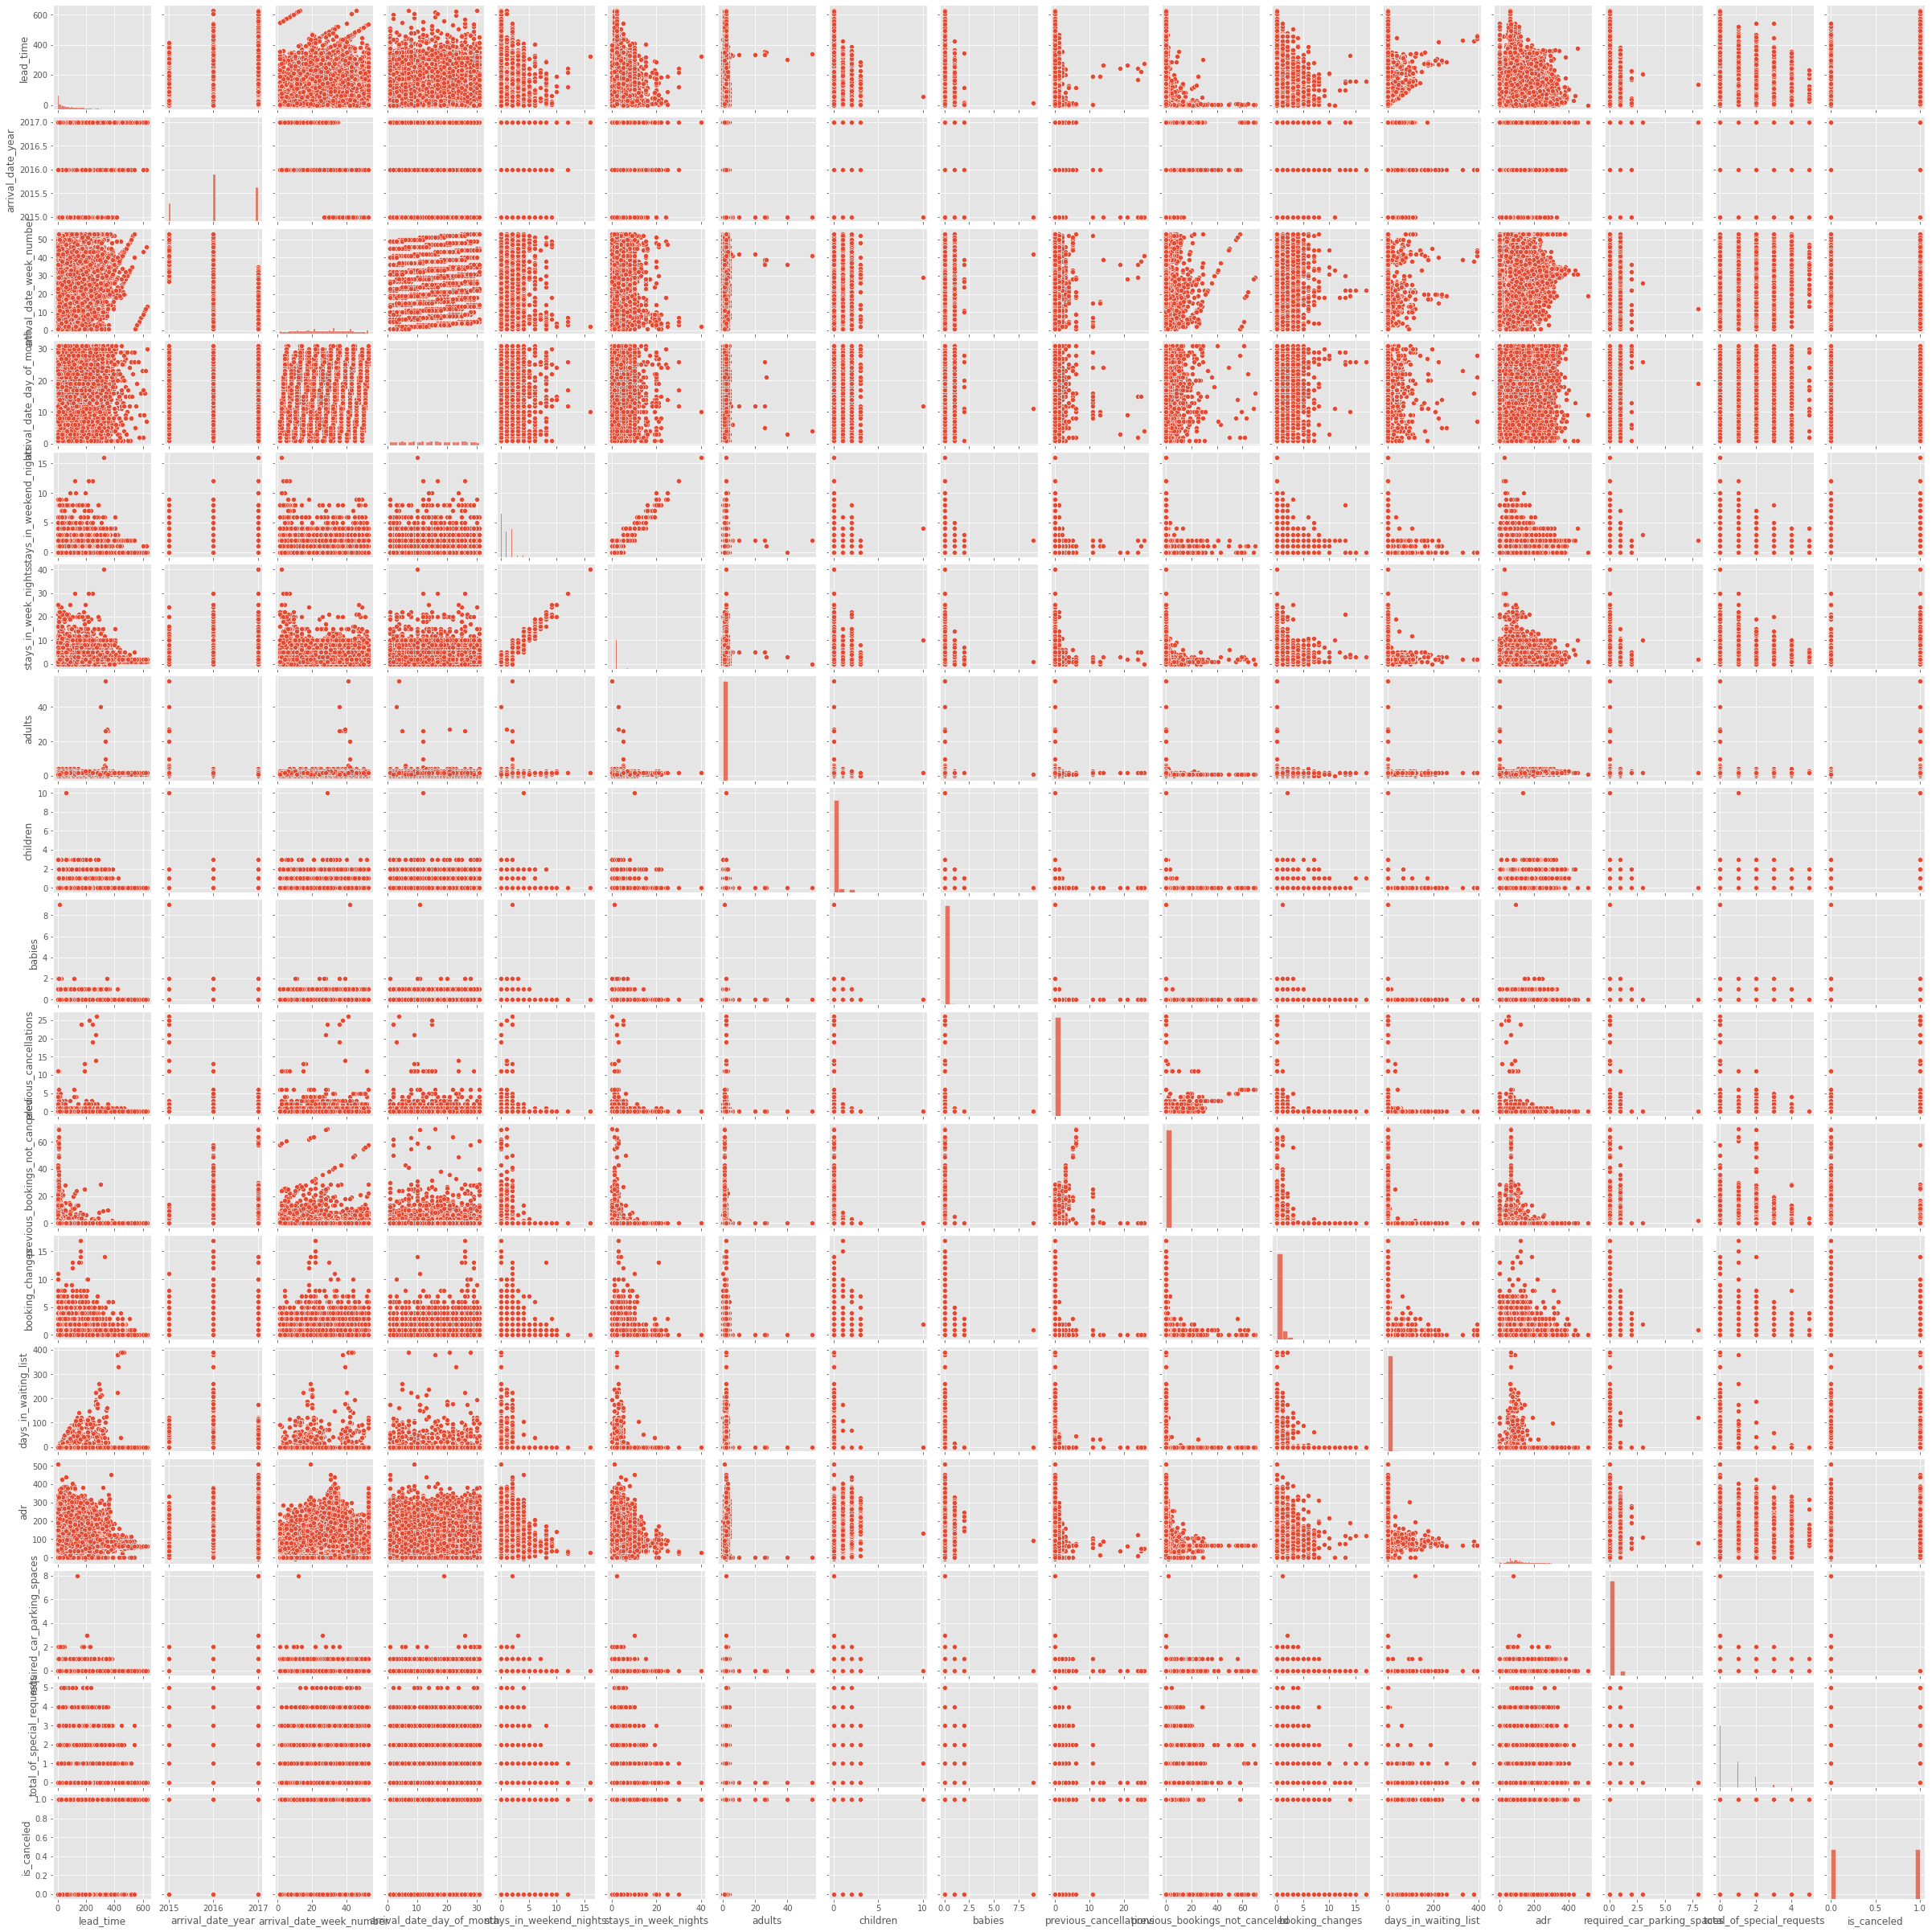

In [166]:
sns.pairplot(hoteles_ds, height=2)

#### Cálculo de correlaciones

<Axes: >

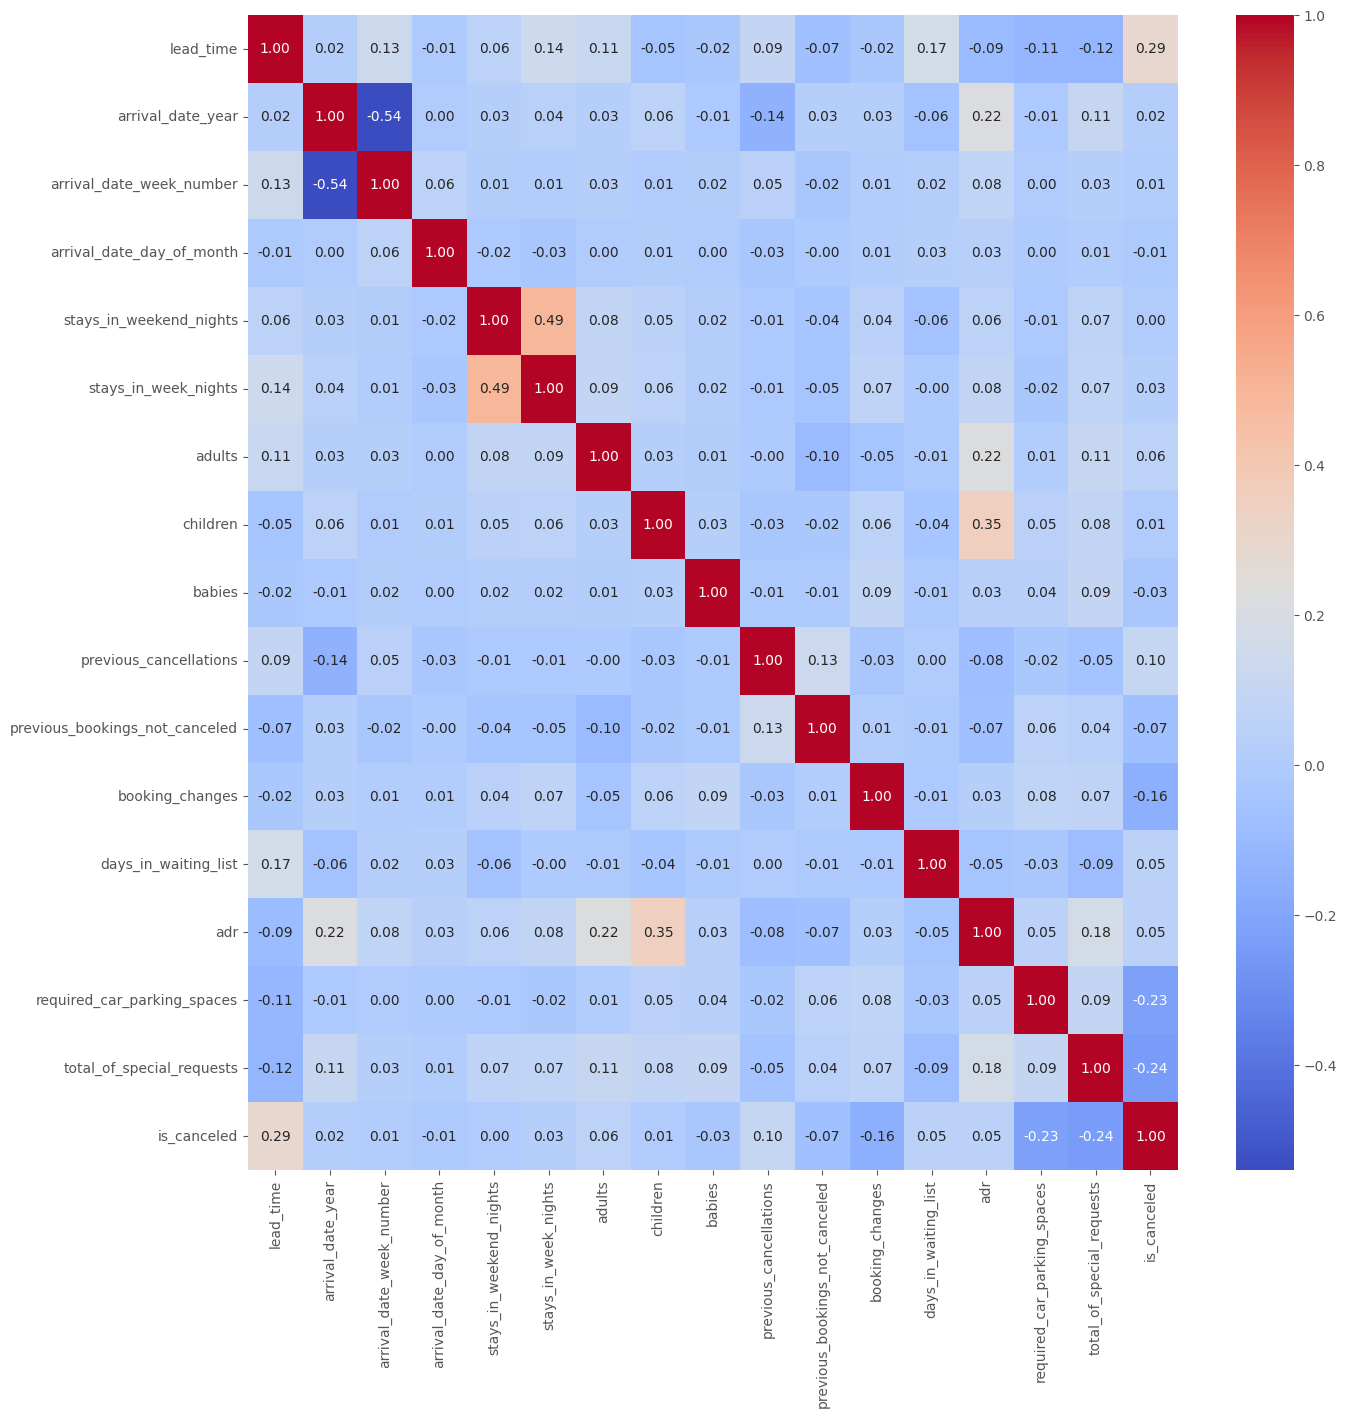

In [54]:
# Calculamos el indice de correlacion de pearson para todas las variables (numericas) y graficamos con un heatmap
corr = hoteles_ds.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')


<Axes: >

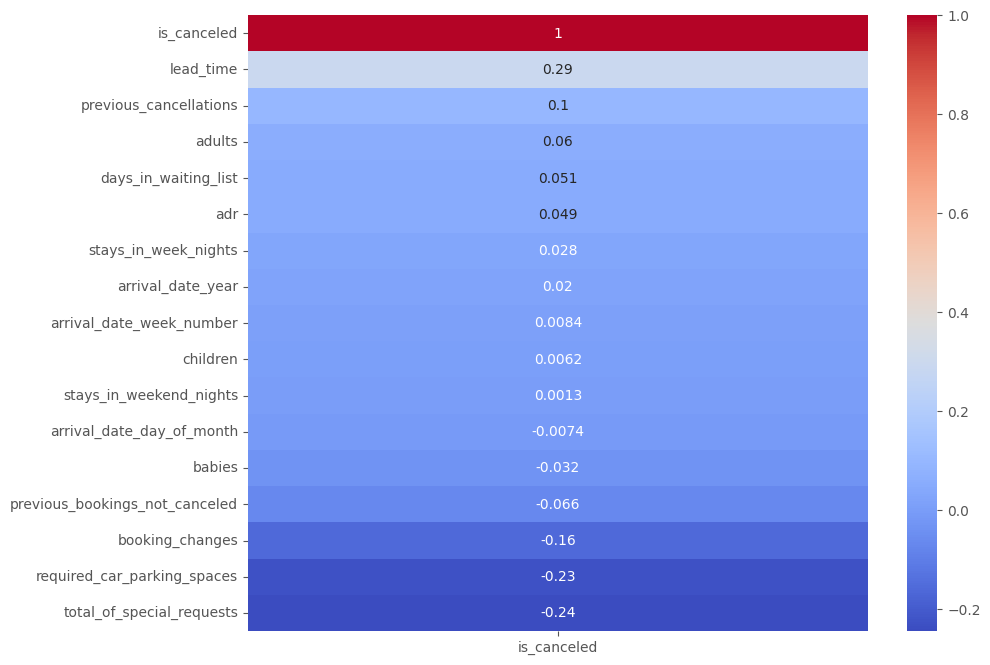

In [55]:
# Analizamos la relacion entre las variables y el target
plt.figure(figsize=(10,8))
sns.heatmap(hoteles_ds.corr(numeric_only=True)[['is_canceled']].sort_values(by='is_canceled', ascending=False), annot=True, cmap='coolwarm')

#### Graficos de relaciones de variables y el estado de cancelacion

Relación entre el tiempo de anticipación y el estado de cancelación

<Axes: xlabel='is_canceled', ylabel='lead_time'>

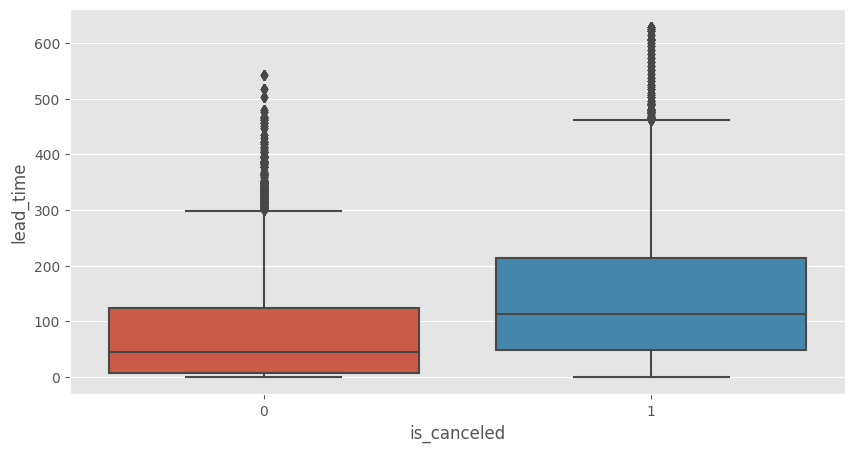

In [56]:
plt.figure(figsize=(10,5))
sns.boxplot(x='is_canceled', y='lead_time', data=hoteles_ds)

Relacion entre la cantidad de pedidos especiales y el estado de la cancelación

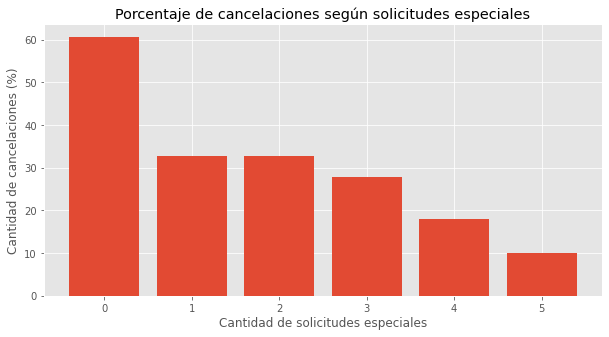

In [213]:
cancelations_by_amount_of_special_requests = hoteles_ds.groupby('total_of_special_requests')['is_canceled'].sum()
reservations_by_amount_of_special_requests = hoteles_ds.groupby('total_of_special_requests')['hotel'].count()
x = [i for i in range(0,6)]
y = [cancelations_by_amount_of_special_requests[i]/reservations_by_amount_of_special_requests[i]*100 for i in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones según solicitudes especiales')
plt.xlabel('Cantidad de solicitudes especiales')
plt.ylabel('Cantidad de cancelaciones (%)')
plt.show()

Relacion entre la cantidad de lugares en el estacionamiento y el estado de la cancelación

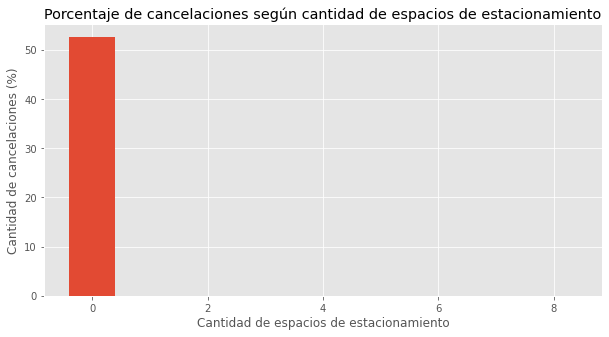

In [214]:
cancelations_by_amount_of_special_requests = hoteles_ds.groupby('required_car_parking_spaces')['is_canceled'].sum()
reservations_by_amount_of_special_requests = hoteles_ds.groupby('required_car_parking_spaces')['hotel'].count()
x = [0,1,2,3,8]
y = [cancelations_by_amount_of_special_requests[i]/reservations_by_amount_of_special_requests[i]*100 for i in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones según cantidad de espacios de estacionamiento')
plt.xlabel('Cantidad de espacios de estacionamiento')
plt.ylabel('Cantidad de cancelaciones (%)')
plt.show()

Cantidad de cancelaciones por mes, de cada hotel


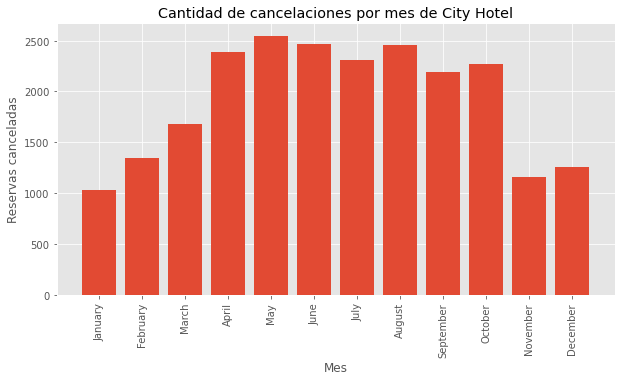

In [215]:
cancelations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'City Hotel'].groupby('arrival_date_month')['is_canceled'].sum()
x = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
y = [cancelations_by_month[mes] for mes in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Cantidad de cancelaciones por mes de City Hotel')
plt.xlabel('Mes')
plt.ylabel('Reservas canceladas')
plt.show()

Vemos que hay una grande variación, pero tal vez se debe al número de reservas por cada mes. Para eliminar esa variable del gráfico, vamos a graficar el porcentaje de las reservas que fueron canceladas cada mes:

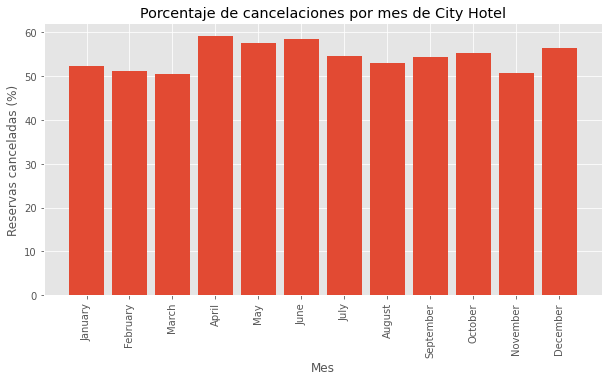

In [216]:
reservations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'City Hotel'].groupby('arrival_date_month')['hotel'].count()
x = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
y = [cancelations_by_month[mes]/reservations_by_month[mes]*100 for mes in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Porcentaje de cancelaciones por mes de City Hotel')
plt.xlabel('Mes')
plt.ylabel('Reservas canceladas (%)')
plt.show()

Hacemos lo mismo para el Resort Hotel:

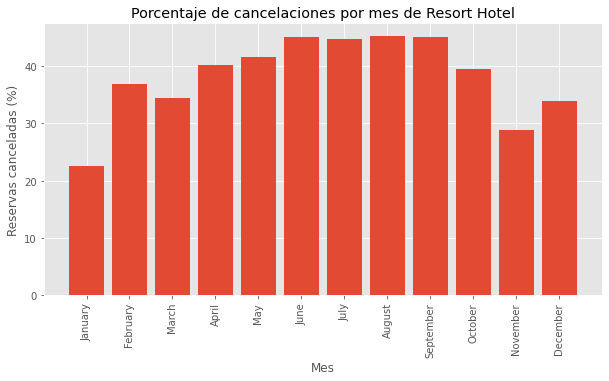

In [217]:
cancelations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['is_canceled'].sum()
reservations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['hotel'].count()
x = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
y = [cancelations_by_month[mes]/reservations_by_month[mes]*100 for mes in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Porcentaje de cancelaciones por mes de Resort Hotel')
plt.xlabel('Mes')
plt.ylabel('Reservas canceladas (%)')
plt.show()

Porcentaje de cancelaciones por hotel

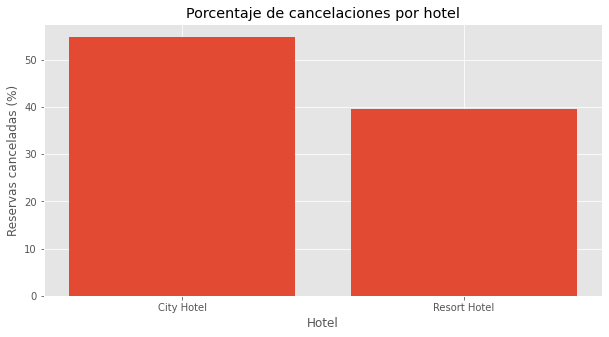

In [10]:
# Get percentaje of cancelations by hotel
cancelations_by_hotel = hoteles_ds.groupby('hotel')['is_canceled'].sum()
reservations_by_hotel = hoteles_ds.groupby('hotel')['hotel'].count()
x = ['City Hotel', 'Resort Hotel']
y = [cancelations_by_hotel[hotel]/reservations_by_hotel[hotel]*100 for hotel in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones por hotel')
plt.xlabel('Hotel')
plt.ylabel('Reservas canceladas (%)')
plt.show()


Porcentaje de cancelaciones por año

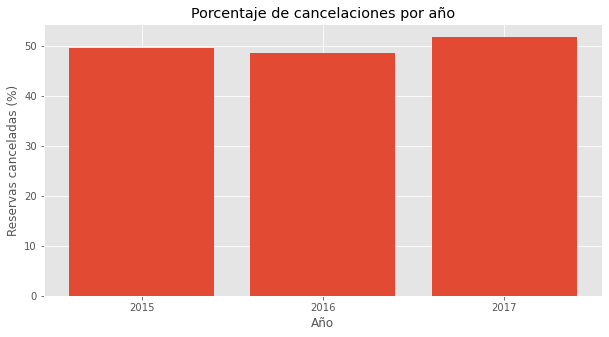

In [11]:

cancelations_by_year = hoteles_ds.groupby('arrival_date_year')['is_canceled'].sum()
reservations_by_year = hoteles_ds.groupby('arrival_date_year')['hotel'].count()
x = ['2015', '2016', '2017']
y = [cancelations_by_year[int(anio)]/reservations_by_year[int(anio)]*100 for anio in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones por año')
plt.xlabel('Año')
plt.ylabel('Reservas canceladas (%)')
plt.show()

Los 30 paises que mas cancelan

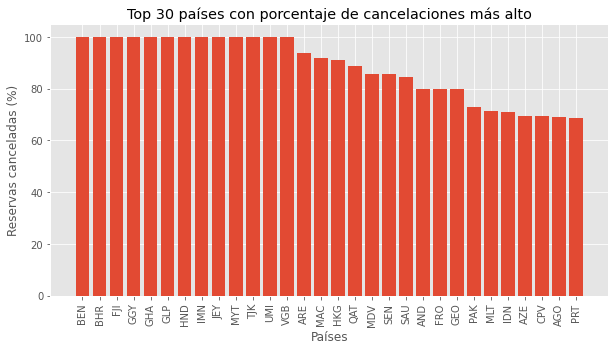

In [219]:
cancelations_by_country = hoteles_ds.groupby('country')['is_canceled'].sum().sort_values(ascending=False)
reservations_by_country = hoteles_ds.groupby('country')['hotel'].count().sort_values(ascending=False)
porcentaje_cancelaciones = cancelations_by_country/reservations_by_country*100
porcentaje_cancelaciones = sorted(porcentaje_cancelaciones.items(), key=lambda x: x[1], reverse=True)
#grafico las 30 mas altas
x = [pais[0] for pais in porcentaje_cancelaciones[:30]]
y = [pais[1] for pais in porcentaje_cancelaciones[:30]]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Top 30 países con porcentaje de cancelaciones más alto')
plt.xlabel('Países')
plt.ylabel('Reservas canceladas (%)')
plt.show()


Cancelaciones según cantidad de bebes

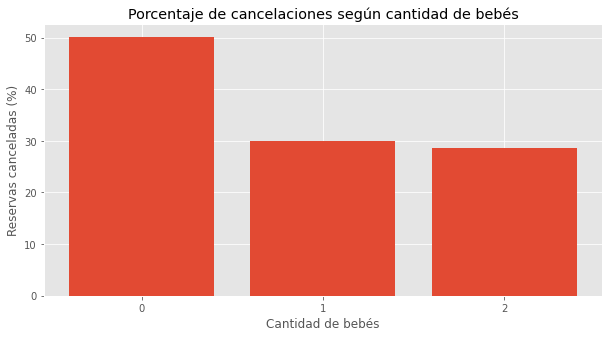

In [220]:
babies_df = hoteles_ds['babies']
cancel_babies = hoteles_ds[hoteles_ds['is_canceled'] == 1]['babies'].value_counts()
reservations_babies = hoteles_ds['babies'].value_counts()

x = ['0', '1', '2']
y = [cancel_babies[i]/reservations_babies[i]*100 for i, _ in enumerate(x)]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones según cantidad de bebés')
plt.xlabel('Cantidad de bebés')
plt.ylabel('Reservas canceladas (%)')
plt.show()


Cancelaciones segun cantidad de "children"

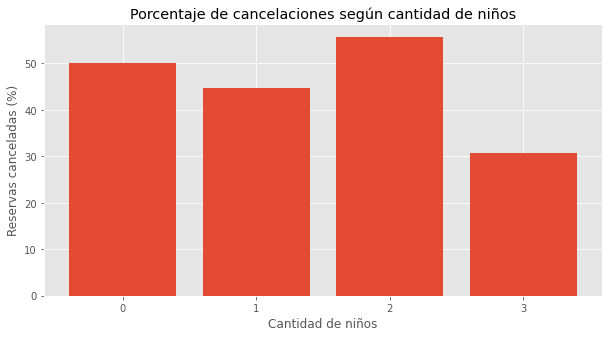

In [48]:
# Get percentaje of cancelations by children ammount
children_df = hoteles_ds['children']
cancel_children = hoteles_ds[hoteles_ds['is_canceled'] == 1]['children'].value_counts()
reservations_children = hoteles_ds['children'].value_counts()

# Plot
x = ['0', '1', '2', '3']
y = [cancel_children[i]/reservations_children[i]*100 for i, _ in enumerate(x)]
plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones según cantidad de niños')
plt.xlabel('Cantidad de niños')
plt.ylabel('Reservas canceladas (%)')
plt.show()

Grafico de distribucion continua de cancelaciones segun costumer_type

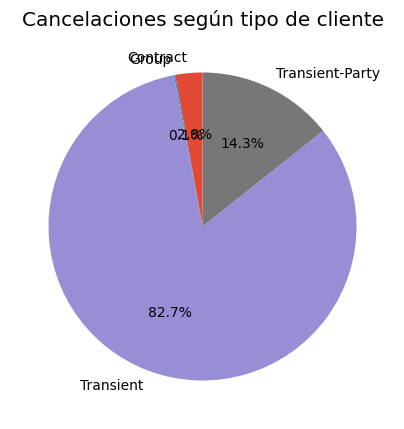

,is_canceled
customer_type,
Contract,878
Group,46
Transient,25585
Transient-Party,4432


In [35]:
df_cancel = hoteles_ds.loc[hoteles_ds['is_canceled'] == 1, ['is_canceled', 'customer_type']]
df_grouped = df_cancel.groupby('customer_type').sum()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(df_grouped['is_canceled'], labels=df_grouped.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Cancelaciones según tipo de cliente')
plt.show()

df_grouped

Grafico de cancelacion de reservas segun BookingChanges

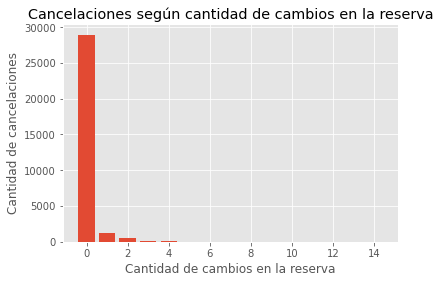

,is_canceled
booking_changes,
0,28949
1,1277
2,538
3,91
4,50
5,13
6,15
7,2
8,3


In [5]:
df_cancelaciones = hoteles_ds.loc[hoteles_ds["is_canceled"] == 1, ["booking_changes", "is_canceled"]]
df_grouped = df_cancelaciones.groupby("booking_changes").sum()

plt.bar(df_grouped.index, df_grouped["is_canceled"])
plt.xlabel("Cantidad de cambios en la reserva")
plt.ylabel("Cantidad de cancelaciones")
plt.title("Cancelaciones según cantidad de cambios en la reserva")
plt.show()

df_grouped


Analisis de la columna "meal". Cancelaciones segun tipo de comida solicitada

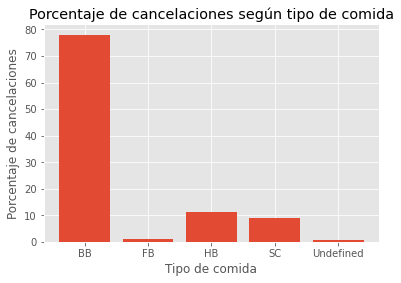

In [9]:
# Get percentage of cancelations by meal type
df_cancelaciones = hoteles_ds.loc[hoteles_ds["is_canceled"] == 1, ["meal", "is_canceled"]]
df_grouped = df_cancelaciones.groupby("meal").sum()
df_grouped["is_canceled"] = df_grouped["is_canceled"] / df_grouped["is_canceled"].sum() * 100

# Plot
plt.bar(df_grouped.index, df_grouped["is_canceled"])
plt.xlabel("Tipo de comida")
plt.ylabel("Porcentaje de cancelaciones")
plt.title("Porcentaje de cancelaciones según tipo de comida")
plt.show()


#### Analisis de informacion de algunas variables

Análisis de variabilidad de datos en la columna country

In [88]:
country_counts = hoteles_ds['country'].value_counts()
country_percentages = country_counts / len(hoteles_ds) * 100
country_table = pd.concat([country_counts, country_percentages], axis=1, keys=['Respuestas', 'Porcentaje'])
country_table = country_table.sort_values(by='Porcentaje', ascending=False)
country_table

,Respuestas,Porcentaje
PRT,27950,45.143992
GBR,5733,9.259768
FRA,4809,7.767351
ESP,4210,6.799864
DEU,3312,5.349442
...,...,...
SDN,1,0.001615
NAM,1,0.001615
MCO,1,0.001615
STP,1,0.001615


Observamos que esta columna tiene casi la mitad con la mismo pais y muchas con un solo pais, consideramos esta columna no aporte informacion significativa y decidimos eliminarla

In [89]:
hoteles_ds = hoteles_ds.drop('country', axis=1)


Analisis de variabilidad de datos en la columna company

In [90]:
company_counts = hoteles_ds['company'].value_counts()
company_percentages = company_counts / len(hoteles_ds) * 100
company_table = pd.concat([company_counts, company_percentages], axis=1, keys=['Datos', 'Porcentaje'])
company_table = company_table.sort_values(by='Porcentaje', ascending=False)
company_table

,Datos,Porcentaje
40.0,390,0.629916
223.0,364,0.587922
67.0,169,0.272964
45.0,118,0.190590
153.0,106,0.171208
...,...,...
398.0,1,0.001615
100.0,1,0.001615
312.0,1,0.001615
96.0,1,0.001615


Observamos que esta columna nos da muy poca informacion, asi que decidimos eliminarla tambien

In [91]:
hoteles_ds = hoteles_ds.drop('company', axis=1)

### Datos Faltantes

##### Heatmap

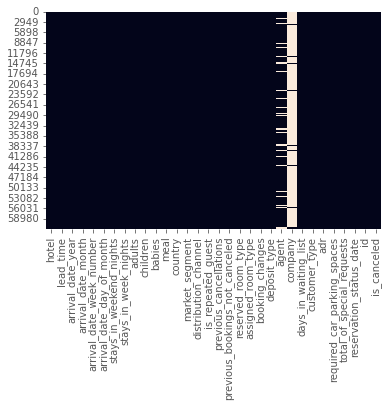

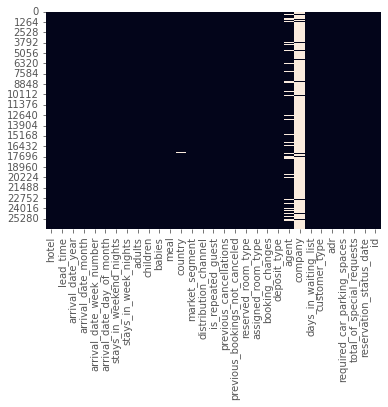

In [186]:
sns.heatmap(hoteles_ds.isnull(), cbar=False)
plt.show()
sns.heatmap(hoteles_test_ds.isnull(), cbar=False)
plt.show()

##### Valores nulos por columna

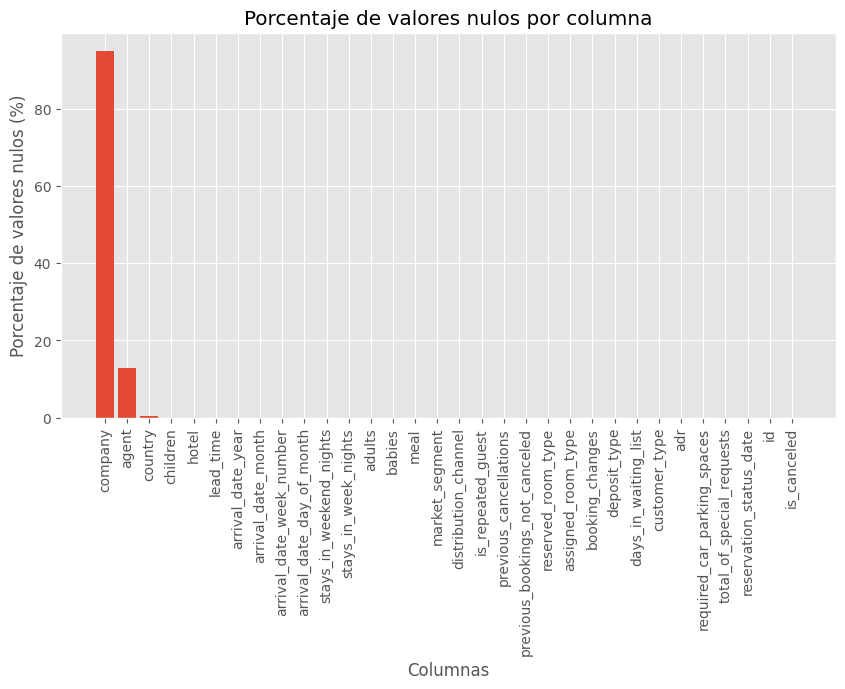

In [57]:
nulls_by_column = hoteles_ds.isnull().mean()*100
nulls_by_column = sorted(nulls_by_column.items(), key=lambda x: x[1], reverse=True)
x = [columna[0] for columna in nulls_by_column]
y = [columna[1] for columna in nulls_by_column]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de valores nulos (%)')
plt.show()

Observacion del numero exacto de nulos por columna


In [164]:
vars_with_na = [var for var in hoteles_ds.columns if hoteles_ds[var].isnull().sum() > 0]

for var in vars_with_na:
    print(f"{var}: {hoteles_ds[var].isnull().sum()} datos faltantes ({np.round(hoteles_ds[var].isnull().mean() * 100, 2)}%)")

country: 221 datos faltantes (0.36%)
agent: 7890 datos faltantes (12.74%)
company: 58761 datos faltantes (94.91%)


Pruebas con datos faltantes

In [39]:
#hoteles_ds.dropna(subset=['children', 'country'], inplace=True)

# Nos dimos cuenta que eliminar las filas con 'country' vacío,
# baja la precisión del modelo, por lo que decidimos dejarlas como estan
#hoteles_ds.dropna(subset=['children'], inplace=True)

# Probamos reemplazar los nulos de 'children' por 0
def fix_children(df):
    # Convertimos children a int. No tiene sentido que sea float
    df['children'].fillna(0, inplace=True)
    df['children'] = df['children'].astype('int64')
    
fix_children(hoteles_ds)
fix_children(hoteles_test_ds)


### Valores Atipicos

##### Variable adults

<Axes: xlabel='adults'>

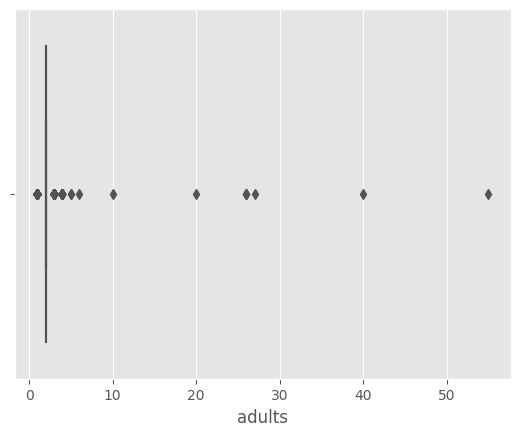

In [81]:
sns.boxplot(x='adults', data=hoteles_ds)

Decidimos eliminar aquellas reservas que no tuvieran adultos

In [80]:
hoteles_ds = hoteles_ds.drop(hoteles_ds[hoteles_ds['adults'] == 0].index)


In [47]:
# from scipy.stats import median_abs_deviation
# mad = median_abs_deviation(hoteles_ds['adults'])
# median = hoteles_ds['adults'].median()
# hoteles_ds['modified_zscore'] = 0.6745 * (hoteles_ds['adults'] - median) / mad
# outliers = hoteles_ds[(hoteles_ds['modified_zscore'] < -3) | (hoteles_ds['modified_zscore'] > 3)]
# outliers


##### Variable babies

<Axes: xlabel='babies'>

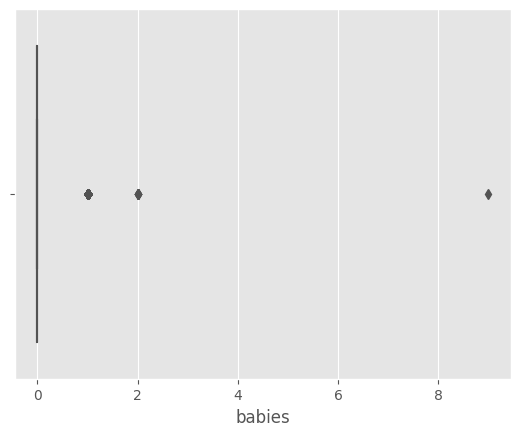

In [82]:
sns.boxplot(x='babies', data=hoteles_ds)

Dedicimos eliminar la fila con mas de 8 bebes

In [83]:
hoteles_ds = hoteles_ds.drop(hoteles_ds[hoteles_ds['babies'] > 8].index)


##### Variable children

<Axes: xlabel='children'>

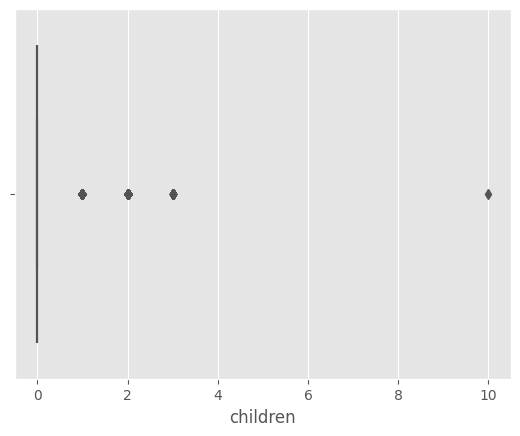

In [65]:
sns.boxplot(x='children', data=hoteles_ds)

Decidimos eliminar la fila con mas de 8 ninios

In [67]:
hoteles_ds = hoteles_ds.drop(hoteles_ds[hoteles_ds['children'] > 8].index)


### Generamos nuevos datos

Probamos con el dato del dia de la semana y la precision baja

In [51]:
def day_of_week(df):
    if 'arrival_day_of_Week' in df.columns:
        df.drop('arrival_day_of_Week', axis=1, inplace=True)
        
    # Extract date from columns 'arrival_date_year', 'arrival_date_month' and 'arrival_date_day_of_month'
    df['arrival_date'] = df.apply(lambda row: datetime(row['arrival_date_year'], list(calendar.month_name).index(row['arrival_date_month']), row['arrival_date_day_of_month']), axis=1)
    # Extract day of week from 'arrival_date'
    df['arrival_day_of_week'] = df['arrival_date'].apply(lambda date: date.weekday())
    # Drop 'arrival_date'
    df.drop('arrival_date', axis=1, inplace=True)
    
    return df

hoteles_ds = day_of_week(hoteles_ds)
hoteles_test_ds = day_of_week(hoteles_test_ds)

### Encodeo de strings

In [52]:
from sklearn import preprocessing


le = preprocessing.LabelEncoder()

def encode_columns(df):
    df.fillna(value="null", inplace=True)
    
    # Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
    df['meal'] = df['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
    # One Hot Encoding
    df = pd.get_dummies(df, columns=['assigned_room_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['customer_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['deposit_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['distribution_channel'], drop_first=True)
    df = pd.get_dummies(df, columns=['hotel'], drop_first=True)
    df = pd.get_dummies(df, columns=['meal'], drop_first=True)
    df = pd.get_dummies(df, columns=['reserved_room_type'], drop_first=True)
    

    # Label encoding
    df['arrival_date_month'] = le.fit_transform(df['arrival_date_month'])
    df['agent'] = le.fit_transform(df['agent'])
    df['company'] = le.fit_transform(df['company'])
    df['country'] = le.fit_transform(df['country'])
    df['id'] = le.fit_transform(df['id'])
    df['market_segment'] = le.fit_transform(df['market_segment'])
    df['is_repeated_guest'] = le.fit_transform(df['is_repeated_guest'])
    df['reservation_status_date'] = le.fit_transform(df['reservation_status_date'])

    return df


### Entrenamiento del modelo

In [53]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

TESTING = True
ITERATIONS = 100 # Default: 100
SOLVER = 'newton-cg' # Default: 'lbfgs
# Solver values: ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

lr = LogisticRegressionCV(max_iter=ITERATIONS, solver=SOLVER)
#pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=ITERATIONS, solver=SOLVER, n_jobs=-1))

hoteles_train_ds = hoteles_ds.copy()
hoteles_test_test_ds = hoteles_test_ds.copy()
non_encoded_id_column_test = hoteles_test_test_ds['id']

# Encodeamos las columnas de nuestro dataset
hoteles_train_ds = encode_columns(hoteles_train_ds)
hoteles_test_test_ds = encode_columns(hoteles_test_test_ds)


# Añadimos las columnas que faltan en el dataset de testeo con valores = 0
# Estas columnas faltantes existen por hacer One Hot Encoding
# Está bien ponerles valor = 0 porque no hay ninguna reserva con el dato faltante (sino no faltaría)
# Si hubiera alguna reserva con el dato, se agregaría automaticamente la columna al usar One Hot Encoding
for col in hoteles_train_ds.copy().drop('is_canceled', axis=1).columns:
    if col not in hoteles_test_test_ds.columns:
        hoteles_test_test_ds[col] = 0



# Nuestro dataset filtrado
x = hoteles_train_ds.copy().drop('is_canceled', axis=1)
y = hoteles_train_ds['is_canceled']

# Ordenamos las columnas para que ambos datasets coincidan
x = x.reindex(sorted(x.columns), axis=1)
hoteles_test_test_ds = hoteles_test_test_ds.reindex(sorted(hoteles_test_test_ds.columns), axis=1)


if TESTING:
    # Generamos un dataset de testeo para medir la precision del modelo.
    # En este paso se reduce el tamaño del dataset de entrenamiento, por lo que
    # solo lo usamos para probar, no para subir las predicciones.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=73)
    
    # Mostramos la info de precision
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    #pipe.fit(x_train, y_train)
    #y_pred = pipe.predict(x_test)

    print(f"Precision: {accuracy_score(y_test, y_pred)}")

else:
    # Usamos el dataset completo para entrenar el modelo
    x_train = x
    y_train = y
    x_test = hoteles_test_test_ds.copy()

    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    #pipe.fit(x_train, y_train)
    #y_pred = pipe.predict(x_test)

    # Generamos el archivo de predicciones
    predicts = pd.DataFrame({'id': non_encoded_id_column_test, 'is_canceled': y_pred})
    predicts.to_csv('../predicts.csv', index=False)
